In [203]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [144]:

def build_dataset(words):
    context_len = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * context_len
    
        for l in w + '.':
            ix = stoi[l]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), "->", itos[ix])
            context = context[1:] + [ix]
        
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
        
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [145]:
C = torch.randn(27, 2)
emb = C[Xtr] # each element of X(corresponding to each letter in the context) is given the appropriate 2-D weight
emb.size()

torch.Size([182625, 3, 2])

In [146]:
emb_c = emb.view(Ytr.size(0), -1)
emb_c.size()

torch.Size([182625, 6])

In [147]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [148]:
h = torch.tanh(emb_c @ W1 + b1)
h.size()

torch.Size([182625, 100])

In [149]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
W2.size()

torch.Size([100, 27])

In [150]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
probs.size()

torch.Size([182625, 27])

In [151]:
import torch.nn.functional as F

loss = -probs[torch.arange(Ytr.shape[0]), Ytr].log().mean()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(16.2645)

In [228]:
# Consolidation
C = torch.randn(27, 10)
W1 = torch.randn(30, 300)
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)

In [229]:
parameters  = [C, W1, b1, W2, b2]
steps = []
losses = []

for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters)

17697

In [248]:
num_iter = 10000
for i in range(num_iter):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.001 #Set as 0.1 initially, decay by a factor of 10 after ~20000 iterations and checking validation loss
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

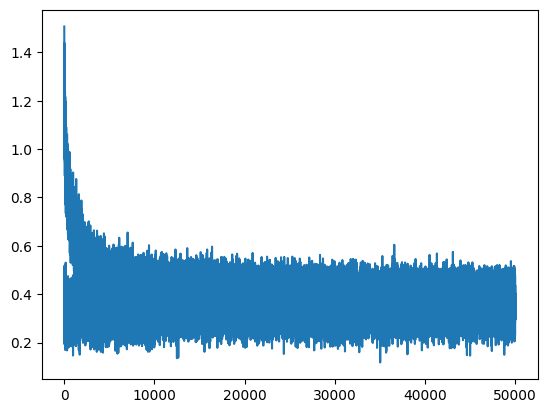

In [245]:
plt.plot(steps, losses)

In [249]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1384, grad_fn=<NllLossBackward0>)

In [250]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1718, grad_fn=<NllLossBackward0>)

In [252]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1721, grad_fn=<NllLossBackward0>)

Final losses:
Training: ~2.13
Validation: 